## Install packages

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!pip install shap
!pip install geemap

!pip install geemap[extra]

#!pip install geojson

## Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import os, json

import ipyleaflet

import ipywidgets as widgets
from IPython.display import display

#from ipywidgets import Layout

import ee
import geemap

#geemap.update_package()

from pprint import pprint

from google.colab import files
#from google.colab import output
#output.enable_custom_widget_manager()

credentials_in_drive = 0
if geemap.credentials_in_drive():
  geemap.copy_credentials_to_colab()
  credentials_in_drive = 1

Map = geemap.Map()

#if credentials_in_drive == 0 and geemap.credentials_in_colab():
if geemap.credentials_in_colab():
  geemap.copy_credentials_to_drive()

pd.options.display.float_format = '{:,.2f}'.format

## Widgets components

In [4]:
#commont widgets layout

label_layout = widgets.Layout(display="flex", justify_content="flex-end", width="90%")

box_layout = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='center')

sidebar_layout = widgets.Layout(width='98%')

desc_width = {'description_width': '120px'}

### Satellite and bands

In [5]:
satellite_list = [
    'Landsat 7 SR',

    'Landsat 8 SR',
    'Landsat 9 SR',

    'Landsat 7 TOA',

    'Landsat 8 TOA',
    'Landsat 9 TOA',
    'Sentinel-2 SR',
    'Sentinel-2 TOA']

collections_list = [
    'LANDSAT/LE07/C02/T1_L2',

    'LANDSAT/LC08/C02/T1_L2',
    'LANDSAT/LC09/C02/T1_L2',

    'LANDSAT/LE07/C02/T1_TOA',
    'LANDSAT/LC08/C02/T1_TOA',
    'LANDSAT/LC09/C02/T1_TOA',
    'COPERNICUS/S2_SR_HARMONIZED',
    'COPERNICUS/S2_HARMONIZED']

bands_list = [
    ['SR_B'+str(i) for i in range(1,6)] + ['SR_B7', 'ST_B6'],
    ['SR_B'+str(i) for i in range(1,8)] + ['ST_B10'],
    ['SR_B'+str(i) for i in range(1,8)] + ['ST_B10'],

    ['B'+str(i) for i in range(1,6)] + ['B7', 'B8'],
    ['B'+str(i) for i in range(1,12)],
    ['B'+str(i) for i in range(1,12)],
    ['B'+str(i) for i in range(1,10)] + ['B8A', 'B11', 'B12'],
    ['B'+str(i) for i in range(1,13)] + ['B8A'],
]

w_satellite = widgets.Dropdown(
    options=satellite_list,
    value='Landsat 9 SR',
    description='Satellite',
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

ind = satellite_list.index(w_satellite.value)

w_select_bands = widgets.SelectMultiple(
    options=bands_list[ind],
    value=bands_list[ind][1:6],
    rows=6,
    description='Bands',
    style=desc_width,
    layout=sidebar_layout,
    disabled=False
)

def satellite_handler(change):
  ind = satellite_list.index(change.new)
  #print(change.new, ', bands[{}]'.format(ind), bands_list[ind])
  w_select_bands.options = bands_list[ind]
  w_select_bands.value = bands_list[ind][1:6]

w_satellite.observe(satellite_handler, names='value')

#display(w_satellite, w_select_bands)


### Region of interest

There are several ways you can create a region for generating the training dataset.

- Draw a shape (e.g., rectangle) on the map and then use `region = Map.user_roi`
- Define a geometry, such as `region = ee.Geometry.Rectangle([-122.6003, 37.4831, -121.8036, 37.8288])`
- Create a buffer zone around a point, such as `region = ee.Geometry.Point([-122.4439, 37.7538]).buffer(10000)`
- If you don't define a region, it will use the image footprint by default

```
image = (
  ee.ImageCollection(collection)
    .filterBounds(region)
    .filterDate(start_date, end_date)
    .map(maskL8sr)
    .median()
    .select(bands)
    .clip(region)
)
```

In [6]:
region_options = [
    'Select an option', # if unselected, default to map bounds
    'Draw shapes on map', # rectangle, polygon. If a point, use next option
    'Input point and buffer', # input point coordinates and buffer distance
    'Rectangle from BBox', # input bounding box coordinates
    'Upload GeoJSON', # upload geometry in .GeoJSON
    ]

w_region = widgets.Dropdown(
    options=region_options,
    value='Select an option',
    description='Region',
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

w_region_detail = widgets.VBox()

def regions_handler(change):
  if change.new == 'Draw shapes on map':
    w_region_detail.children = [widgets.Label(value="Please draw geometry on the map.",
                                              layout=label_layout)]

  elif change.new == 'Input point and buffer':
    w_point = widgets.Text(description='Lon, Lat',
                           style=desc_width,
                           layout=sidebar_layout)
    w_buffer = widgets.FloatText(description='Buffer (km)',
                                 style=desc_width,
                                 layout=sidebar_layout)
    w_region_detail.children = [w_point, w_buffer]

  elif change.new == 'Rectangle from BBox':
    w_points = widgets.Text(description='BBox (W, S, E, N)',
                            style=desc_width,
                            layout=sidebar_layout)
    w_region_detail.children = [w_points]

  elif change.new == 'Upload GeoJSON':
    w_btn_region = widgets.Button(description='Upload GeoJSON',
                            button_style='danger',
                            tooltip="Upload GeoJSON",
                            #style={'font_size': '3px', 'font_weight': 'bold'}
                            )

    w_btn_region_output = widgets.Output()
    def btn_region_handler(obj):
        w_btn_region_output.clear_output()
        with w_btn_region_output:
          uploaded = files.upload()
          for fn in uploaded.keys():
            global region_json
            region_json = fn
            #print(region_json)

    w_btn_region.on_click(btn_region_handler)
    w_region_detail.children = [w_btn_region, w_btn_region_output]
    #w_region_detail.layout = box_layout

  else:
    w_region_detail.children = [widgets.Label(
        value="Default to current map boundary.",
        layout=label_layout)]

w_region.observe(regions_handler, names='value')
w_regions = widgets.VBox([w_region, w_region_detail])
#display(w_regions)

### DatePicker & temporal interval

In [7]:
# could use string as well
w_start_date = widgets.DatePicker(
    description='Start date',
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

w_end_date = widgets.DatePicker(
    description='End date',
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

w_separate_doy = widgets.Checkbox(description='Separate doy from year',
                                  value=False,
                                  style=desc_width,
                                  layout=sidebar_layout)

w_temporal = widgets.Checkbox(description='Temporal composite',
                              value=False,
                              style=desc_width,
                              layout=sidebar_layout)

temporal_options = [
    'All dates', # just median temporal composite of all scenes
    'Yearly', # temporal composite for each year of all scenes
    'Monthly', # temporal composite for each month of all scenes
    'Daily', # temporal composite for each day of all scenes
]

w_temporal = widgets.Dropdown(
    options=temporal_options,
    value='All dates',
    description='Composite interval',
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

w_temporal_detail = widgets.VBox()

def temporal_handler(change):
  if change.new == 'All dates':
    w_temporal_detail.children = [widgets.Label(value="Median composite for the entire interval",
                                                layout=label_layout)]
  elif change.new == 'Yearly':
    w_temporal_detail.children = [widgets.Label(value="Yearly median composite",
                                                layout=label_layout)]
  elif change.new == 'Monthly':
    w_temporal_detail.children = [widgets.Label(value="Monthly median composite",
                                                layout=label_layout)]
  elif change.new == 'Daily':
    w_temporal_detail.children = [widgets.Label(value="Daily mosaic",
                                                layout=label_layout)]

w_temporal.observe(temporal_handler, names='value')

w_dates = widgets.VBox([
    w_start_date,
    w_end_date,
    #w_separate_doy,
    w_temporal,
    w_temporal_detail
])


### Spectal indices & other variables

In [8]:
w_spectral_indices = widgets.SelectMultiple(
    options=['None', 'NDVI', 'NDWI', 'NBR'],
    value=['None'],
    description='Spectral indices',
    rows=3,
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

w_variables = widgets.SelectMultiple(
    options=['Elevation', 'Slope'],
    value=[],
    description='Other variables',
    rows=3,
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

w_split_ratio = widgets.BoundedFloatText(
    value=0.7,
    min=0.1,
    max=1,
    step=0.01,
    description='Split ratio',
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

### Multi-source checkbox

If multi-source classification, select multiple satellites and their bands.
```
pprint(multiSource)

{'Landsat 9 SR': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6'],
 'Sentinel-2 TOA': ['B2', 'B3', 'B4', 'B5', 'B6']}
```

In [9]:
w_multiSource = widgets.Checkbox(description='Multi-source',
                                 value=False,
                                 style=desc_width,
                                 layout=sidebar_layout)

# global variable: a dict storing satellite and bands lists for classification
multiSource = {}

def multiSourceChanged(value):
    if value['new'] == True:
      #w_btn_addSource.layout.visibility = "visible"
      w_btn_addSource.layout.display = "block"
      with w_btn_addSource_output:
        print('Select satellite/bands, then click "Add source" button.')
    else:
      w_btn_addSource_output.clear_output()
      multiSource.clear()
      #w_btn_addSource.layout.visibility = "hidden"
      w_btn_addSource.layout.display = "none"

w_multiSource.observe(multiSourceChanged, names='value')

w_btn_addSource = widgets.Button(description='Add source',
                            button_style='danger',
                            tooltip="Add satellite/bands",
                            #layout=widgets.Layout(visibility='hidden')
                            layout=widgets.Layout(display='none')
                            )

w_btn_addSource_output = widgets.Output()
def btn_addSource_handler(obj):
    w_btn_addSource_output.clear_output()
    with w_btn_addSource_output:
      #print('Added satellite/bands for', w_satellite.value)
      multiSource[w_satellite.value] = list(w_select_bands.value)
      print('Current selection')
      pprint(multiSource)

w_btn_addSource.on_click(btn_addSource_handler)

w_source = widgets.VBox([#widgets.HBox([w_multiSource, w_btn_addSource]),
                         w_multiSource,
                         w_btn_addSource,
                         w_btn_addSource_output])

if 0:
  display(w_satellite, w_select_bands)
  display(w_source)

  #pprint(multiSource)
  display(w_classifier)

### Classifier


In [10]:
classifier_list = [
    'CART',
    'RandomForest',
    #'NaiveBayes',
    #'SVM',
    #'decisionTree',
]

w_cart_param = [
    widgets.BoundedIntText(
        value=1000,
        min=1,
        max=1000,
        step=1,
        description='maxNodes',
        disabled=True,
        style=desc_width,
        layout=sidebar_layout
    ),
    widgets.BoundedIntText(
        value=1,
        min=1,
        max=1000,
        step=1,
        description='minLeafPopulation',
        disabled=True,
        style=desc_width,
        layout=sidebar_layout
    ),
]

w_rf_param = [
    widgets.BoundedIntText(
        value=100,
        min=1,
        max=1000,
        step=1,
        description='numberOfTrees',
        disabled=True,
        style=desc_width,
        layout=sidebar_layout
    ),
    widgets.BoundedIntText(
        value=10,
        min=1,
        max=1000,
        step=1,
        description='variablesPerSplit',
        disabled=True,
        style=desc_width,
        layout=sidebar_layout
    ),
    widgets.BoundedIntText(
        value=1,
        min=1,
        max=100,
        step=1,
        description='minLeafPopulation',
        disabled=True,
        style=desc_width,
        layout=sidebar_layout
    ),
    widgets.BoundedFloatText(
        value=0.5,
        min=0.01,
        max=1,
        step=0.01,
        description='bagFraction',
        disabled=True,
        style=desc_width,
        layout=sidebar_layout
    ),
    widgets.BoundedIntText(
        value=1000,
        min=1,
        max=1000,
        step=1,
        description='maxNodes',
        disabled=True,
        style=desc_width,
        layout=sidebar_layout
    ),
]

classifier_param ={
    'CART': w_cart_param,
    'RandomForest': w_rf_param
}

w_classifier_select = widgets.Dropdown(
    options=classifier_list,
    value='RandomForest',
    description='Select classifier',
    style=desc_width,
    layout=sidebar_layout
)

w_classifier_customize = widgets.Checkbox(description='Customize parameters',
                                          value=False,
                                          style=desc_width,
                                          layout=sidebar_layout)

w_classifier_param = widgets.VBox()

#layout=widgets.Layout(border='1px solid black', justify_content='flex-end')

def classifier_handler(change):
  if w_classifier_customize.value:
    w_classifier_param.children = classifier_param[change.new]
    for w in w_classifier_param.children:
      w.disabled=False

w_classifier_select.observe(classifier_handler, names='value')

def classifier_customizeChanged(value):
    if value['new'] == False:
      w_classifier_param.children=[]
    else:
      w_classifier_param.children = classifier_param[w_classifier_select.value]
      for w in w_classifier_param.children:
        w.disabled=False

w_classifier_customize.observe(classifier_customizeChanged, names='value')

w_classifier = widgets.VBox([w_classifier_select, w_classifier_customize, w_classifier_param],
                            layout={'border': '1px solid green'})

#display(w_classifier)

### Widget output control on map

In [11]:
w_map_output = widgets.Output(layout={'border': '1px solid black',
                                      #'width': '200px'
                                      })
output_control = ipyleaflet.WidgetControl(widget=w_map_output, position='bottomleft')
Map.add_control(output_control)

### Workflow buttons

In [12]:
# Workflows:
# check user input, load label/geometry data from csv,
# filter image collections, get train/test data,
# add layers to map, including labeled points and image
# train/assess classifier,
# classify image and display classification on map
# examine feature importance: gee, scikit-learn, shap
# calculate zonal statistics

w_classified_flag = widgets.Checkbox(description='Image classified?', value=False)

w_classified_tmpflag = widgets.Checkbox(description='Temporal composite classified?', value=False)

w_btn_workflow_log = widgets.Output(layout={'border': '2px solid blue',
                                            'height': '200px',
                                            'overflow': 'auto'})

w_btn_classify = widgets.Button(description='Classify',
                           button_style='danger',
                           tooltip="Filter image collection and classify image",
                           layout=widgets.Layout(width='80%'))

def btn_classify_handler(obj):
  w_btn_workflow_log.clear_output()
  w_map_output.clear_output()

  w_classified_flag.value = False
  w_classified_tmpflag.value = False

  with w_btn_workflow_log:
    global imageMedian
    print('Step 1/3: Get composite image')
    imageMedian = getImage()

    print('\nStep 2/3: Get samples data')
    getSamplesData(imageMedian)

    print('\nStep 3/3: Classify the image')
    runGeeClassifier(imageMedian)
    print('\nDONE.')

    w_classified_flag.value = True
    w_map_output.clear_output()
    # enable w_btn_features
    w_btn_features.disabled=False

w_btn_classify.on_click(btn_classify_handler)

# w_feature_output is used to capture output of showFeatureImportance()
#w_feature_output = widgets.Output()
w_btn_features = widgets.Button(description='Feature importance',
                           button_style='danger',
                           disabled=True,
                           tooltip="Calculate and display feature importance")

def btn_features_handler(obj):
  ctab = showFeatureImportance()
    #display(ctab)

w_btn_features.on_click(btn_features_handler)

### Samples from labeled points uploaded

Upload csv file, each row represents a sample (lon, lat, class, date if any).

There are some issues with widgets.FileUpload(). The Colab file.upload() is used instead.

In [13]:
sample_csv = None
CLASS_NAMES = None
CLASS_PALETTE = None

w_btn_sample = widgets.Button(description='Upload samples',
                            button_style='danger',
                            tooltip="Sample format: (lon, lat, label, date)",
                            style=desc_width
                            #layout=sidebar_layout
                            )

w_includeLabels = widgets.Checkbox(description='Class names included',
                                   value=False,
                                   style=desc_width, #layout=sidebar_layout
                                   )

w_class_labels = widgets.Text(
    description='Class names',
    placeholder='Comma-seperated names',
    layout=widgets.Layout(width='98%'),
    style=desc_width,
    #layout=sidebar_layout
)

w_btn_sample_output = widgets.Output()
def btn_sample_handler(obj):
    w_btn_sample_output.clear_output()
    with w_btn_sample_output:
      uploaded = files.upload()

      for fn in uploaded.keys():
        # global file name
        global sample_csv
        sample_csv = fn
      # read in sample_csv, display color picker for each class
      #getLabelData(sample_csv)

def includeLabelsChanged(value):
    if value['new'] == True:
      #w_class_labels.layout.visibility = "hidden"
      w_class_labels.layout.display = "none"
    else:
      #w_btn_sample_output.clear_output()
      #w_class_labels.layout.visibility = "visible"
      w_class_labels.layout.display = "block"
      # to-do: re-display after hidden, somehow the width not rendered properly
      #w_class_labels.layout = widgets.Layout(display='block', width='98%')

w_includeLabels.observe(includeLabelsChanged, names='value')

w_btn_sample.on_click(btn_sample_handler)


In [14]:
w_randomColors = widgets.Checkbox(
    value=True,
    description='Use random colors',
    style=desc_width,
    layout=sidebar_layout
)

w_palette = widgets.VBox()

def randomColorsChanged(value):
  CLASS_NAMES, _ = getClassLabelsFromFile()

  if CLASS_NAMES == None:
    return

  # Populate user-selected colors
  if CLASS_PALETTE is not None:
    random_colors = CLASS_PALETTE
    #class_colors = [c.value for c in w_palette.children]
  else:
    random_colors=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
          for j in range(len(CLASS_NAMES))]

  w_palette.children = [widgets.ColorPicker(
            concise=False,
            description=name,
            value=color,
            disabled=False,
            style=desc_width,
            layout=sidebar_layout)
    for (name, color) in zip(CLASS_NAMES, random_colors)
  ]

  if value['new'] == False:
    w_palette.layout.display = "block"
  else:
    w_palette.layout.display = "none"
    #w_palette.children = []

w_randomColors.observe(randomColorsChanged, names='value')

w_sample1 = widgets.VBox(
    [#widgets.HBox([w_btn_sample, w_includeLabels]),
    w_btn_sample,
    w_btn_sample_output,
    w_includeLabels,
    w_class_labels,
    w_randomColors,
    w_palette]
)


### Samples from LULC products

In [15]:
w_sample_select = widgets.Dropdown(
    options=['Upload samples', 'Sample LULC products'],
    value='Upload samples',
    description='Labeled data',
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

def sample_select_handler(change):
  if change.new == 'Sample LULC products':
    w_sample1.layout.display= "none"
    w_sample2.layout.display= "block"
  else:
    w_sample2.layout.display= "none"
    w_sample1.layout.display= "block"
  # Clear output widgets
  w_btn_workflow_log.clear_output()
  w_map_output.clear_output()

w_sample_select.observe(sample_select_handler, names='value')

lulc_list = [
    'Dynamic World V1',
    'ESA WorldCover 10m v100/200',
    'ESRI Global Land Cover',
]

w_lulc_select = widgets.Dropdown(
    options=lulc_list,
    value='Dynamic World V1',
    description='LULC map',
    disabled=False,
    style=desc_width,
    layout=sidebar_layout
)

w_numPoints = widgets.BoundedIntText(
  value=1000,
  min=100,
  max=100000,
  step=100,
  description='Labels total',
  style=desc_width,
  layout=sidebar_layout
)

w_stratifiedSample = widgets.Checkbox(value=False,
                                      description='Stratified sample',
                                      style=desc_width,
                                      layout=sidebar_layout)

def stratifiedSampleChanged(value):
    if value['new'] == True:
      w_numPoints.description = 'Labels per class'
    else:
      w_numPoints.description = 'Labels total'

w_stratifiedSample.observe(stratifiedSampleChanged, names='value')

w_sample2 = widgets.VBox([w_lulc_select, w_stratifiedSample, w_numPoints],
                         layout=widgets.Layout(display='none'))

w_sample = widgets.VBox([w_sample_select,
                         w_sample1,
                         w_sample2])


In [16]:
@w_btn_workflow_log.capture(clear_output=False, wait=False)
def getClassLabelsFromFile():
  """ Read labels for csv files uploaded """
  #sample_csv = 'landcover_google_sample.csv'

  global LABEL, CLASS_NAMES, LABEL_DATA

  if (w_includeLabels.value == False and w_class_labels.value == ''):
    print('Incomplete input. If sample file does not include class names, enter them as a comma-separated list.')
    return None, None
  if sample_csv is None:
    print('Upload samples first.')
    return None, None

  label_points = pd.read_csv(sample_csv)

  LABEL = label_points.columns[2]

  #Example CLASS_NAMES = ['Urban', 'Vegetation', 'Water']
  CLASS_NAMES = label_points.iloc[:,2].unique()
  CLASS_NAMES.sort()
  CLASS_NAMES = CLASS_NAMES.tolist()

  if w_includeLabels.value == False:
    # Read in class names
    CLASS_NAMES = w_class_labels.value.split(',')

  # Remove possible leading/trailing white spaces
  CLASS_NAMES = [s.strip() for s in CLASS_NAMES]
  #print('Unique labels-class names:', CLASS_NAMES)

  for i, name in enumerate(CLASS_NAMES):
    if w_includeLabels.value:
      # assign class names to 0-indexed consecutive integers
      label_points.loc[label_points[LABEL]==name, LABEL] = i
    else:
      # already 0-indexed integers
      pass
      # assign class names
      #label_points.loc[label_points[LABEL]==i, LABEL] = name

  # check class balance
  #class_count = label_points.groupby(LABEL)[LABEL].count()
  #class_count.index = CLASS_NAMES
  #print(class_count)

  #LABEL_DATA = geemap.df_to_ee(label_points, latitude='lat', longitude='lon')
  LABEL_DATA = geemap.df_to_ee(label_points,
                              latitude=label_points.columns[1],
                              longitude=label_points.columns[0])
  #pprint(LABEL_DATA.first().getInfo())

  return CLASS_NAMES, LABEL_DATA


In [17]:
def getClassLabelsFromLC():
  """ Sample exisiting LULC products for labels """

  global LABEL, CLASS_NAMES, LABEL_DATA, CLASS_PALETTE

  from geemap import legends

  if w_lulc_select.value == 'Dynamic World V1':
    legend = geemap.legends.builtin_legends['Dynamic_World']
  elif w_lulc_select.value == 'ESA WorldCover 10m v100/200':
    legend = geemap.legends.builtin_legends['ESA_WorldCover']
  elif w_lulc_select.value == 'ESRI Global Land Cover':
    legend = geemap.legends.builtin_legends['ESRI_LandCover_TS']

  LABEL = 'Land cover' # hard-coded
  CLASS_NAMES = [name.split(' ', 1)[1] for name in legend.keys()]
  CLASS_LABELS = [int(name.split(' ', 1)[0]) for name in legend.keys()]
  CLASS_PALETTE = list(legend.values())
  CLASS_PALETTE = ['#'+c for c in CLASS_PALETTE if not c.startswith('#')]

  # Sample LULC products selected
  if w_lulc_select.value == 'Dynamic World V1':
    # If no clip region
    #lc = geemap.dynamic_world(region, start_date, end_date, return_type='class')
    # If clip region
    lc = geemap.dynamic_world(region, start_date, end_date, True, return_type='class')

    # Rename band 'label_mode'. No need to remap since dynamic world is 0-indexed labels
    lc = lc.rename(LABEL)

  elif w_lulc_select.value == 'ESA WorldCover 10m v100/200':
    if start_date.split('-')[0] == '2020':
      lc = ee.Image('ESA/WorldCover/v100/2020')
    elif start_date.split('-')[0] == '2021':
      lc = ee.Image('ESA/WorldCover/v200/2021')
    else:
      # Still use 2021 for other years
      print('ESA WorldCover 10m valid years: 2020-2021. Year 2021 used instead.')
      lc = ee.Image('ESA/WorldCover/v200/2021')

    # Remap labels and rename band
    remapped_labels = list(range(0, len(CLASS_LABELS)))
    #lc = lc.remap(CLASS_LABELS, remapped_labels).rename(LABEL).toByte()
    lc = lc.clip(region).remap(CLASS_LABELS, remapped_labels).rename(LABEL)

  elif w_lulc_select.value == 'ESRI Global Land Cover':
    #lc = ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m")
    lc = ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS")

    # Filter dates: seems the filter only works for the entire year 2017-2021
    year = start_date.split('-')[0]
    if year >= '2017' and year <= '2021':
      pass
    else:
      year = '2021'
      print('ESRI Global Land Cover valid years 2017-2021. Year 2021 used instead.')
    lc = lc.filterDate(year+'-01-01', year+'-12-31').mosaic().clip(region)

    # Remap labels and rename band
    remapped_labels = list(range(0, len(CLASS_LABELS)))
    lc = lc.remap(CLASS_LABELS, remapped_labels).rename(LABEL)

  if w_stratifiedSample.value:
    print('Stratified sampling', w_lulc_select.value, '...')
    LABEL_DATA = lc.stratifiedSample(
        **{
            'numPoints': w_numPoints.value,
            'classBand': LABEL,
            'region': region,
            'scale': 10,
            'seed': seed,
            'geometries': True,  # Set this to False to ignore geometries
        }
    )
  else:
    print('Random sampling', w_lulc_select.value, '...')
    LABEL_DATA = lc.sample(
        **{
            'region': region,
            'numPixels': w_numPoints.value,
            'scale': 10,
            'seed': seed,
            'geometries': True,
            'tileScale': 16
        }
    )

  # Add layers: landcover lc and samples LABEL_DATA
  vis_param = {'min': 0, 'max': len(CLASS_PALETTE)-1, 'palette': CLASS_PALETTE}
  Map.addLayer(lc, vis_param, w_lulc_select.value)

  w_map_output.clear_output()
  with w_map_output:
    text = 'Added LULC layer to sample from.'
    htmlWidget = widgets.HTML(value = f"<b><font color='red'>{text}</b>")
    display(htmlWidget)

  return LABEL_DATA, CLASS_PALETTE


## Workflow functions

### Get ROI

In [18]:
"""
region_options = [
    'Select an option', # default to map bounds
    'Draw shapes on map', # rectangle, polygon. If a point, use next option
    'Input point and buffer', # input point coordinates and buffer distance
    'Rectangle from BBox', # input bounding box coordinates
    'Upload GeoJSON', # upload geometry in .geojson
    ]

    with open(os.path.abspath(region_json), encoding="utf-8") as f:
      geo_json = json.load(f)

    if geo_json["type"] == "FeatureCollection":
      region = ee.FeatureCollection(geo_json)
    elif geo_json["type"] == "Feature":
      region = ee.Geometry(geo_json['geometry'])
"""

def getRegion():
  if w_region.value == 'Draw shapes on map':
    print('Use geometry drawn on map')
    region = Map.user_roi

  elif w_region.value == 'Input point and buffer (km)':
    w_point, w_buffer = w_region_detail.children
    coord = w_point.value.split(',')
    coord = [float(a) for a in coord[:2]]
    region = ee.Geometry.Point(coord).buffer(w_buffer.value*1000)

  elif w_region.value == 'Rectangle from BBox':
    w_points = w_region_detail.children[0]
    poly_coord = w_points.value.split(',')
    poly_coord = [float(a) for a in poly_coord]
    #region = ee.Geometry.Polygon(poly_coord)
    region = ee.Geometry.BBox(*poly_coord)

  elif w_region.value == 'Upload GeoJSON':
    #? fixed - geemap could not convert features to ee.geometry
    # however, it could convert feature collections
    region = geemap.geojson_to_ee(region_json)

  elif w_region.value == 'Select an option':
    #region = ee.Geometry(Map.get_bounds(asGeoJSON=True))
    region = ee.Geometry.BBox(*Map.get_bounds())
  else:
    region = None

  return region

### Cloud mask and image scaling


In [19]:
# Cloud masking function.
def maskL89C2coulds(image):
  # For collection 1
  #cloudShadowBitMask = ee.Number(2).pow(3).int()
  #cloudsBitMask = ee.Number(2).pow(5).int()
  #qa = image.select('pixel_qa')

  # For collection 2
  #cloudShadowBitMask = ee.Number(2).pow(4).int()
  #cloudsBitMask = ee.Number(2).pow(3).int()
  #qa = image.select('QA_PIXEL')
  #mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
  #  qa.bitwiseAnd(cloudsBitMask).eq(0))

  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111',2)).eq(0)
  saturationMask = image.select('QA_RADSAT').eq(0)

  return image.updateMask(qaMask).updateMask(saturationMask) \
              .copyProperties(image, ['system:time_start'])

def applyL89srScale(image):
  #LANDSAT 8/9 C02/T1_L2, surface reflectance
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True) \
              .copyProperties(image, ['system:time_start'])

def maskS2clouds(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
      qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000) \
              .copyProperties(image, ['system:time_start'])

### Filter ImageCollection


In [20]:
def filterImageCollection(collection, region, start_date, end_date, bands, return_type='image'):
  """return either an median composite image or an image collection
  """

  image = ee.ImageCollection(collection) \
            .filterDate(start_date, end_date)

  # check if image is empty
  #print('filtered image collection size: ', image.size().getInfo())

  if region is not None:
    image = image.filterBounds(region)

  if collection.startswith('COPERNICUS/S2'):
    image = image.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                 .map(maskS2clouds)
  elif collection.startswith('LANDSAT/L'): # add Landsat 7
    image = image.map(maskL89C2coulds)
  else:
    pass

  # for landsat sr
  if collection.endswith('T1_L2'):
    image = image.map(applyL89srScale)

  image = image.select(bands)

  if return_type == 'image':
    image = image.median()
    if region is not None:
      if isinstance(region, ee.geometry.Geometry):
        image = image.clip(region)
      elif isinstance(region, ee.featurecollection.FeatureCollection):
        image = image.clipToCollection(region)
    return image
  else:
    if region is not None:
      if isinstance(region, ee.geometry.Geometry):
        image = image.map(lambda img: img.clip(region))
      elif isinstance(region, ee.featurecollection.FeatureCollection):
        image = image.map(lambda img: img.clipToCollection(region))
    return image


### Spectral indices/variables

```
satellite_list = [
    'Landsat 7 SR',
    'Landsat 8 SR',
    'Landsat 9 SR',
    'Landsat 7 TOA',
    'Landsat 8 TOA',
    'Landsat 9 TOA',
    'Sentinel-2 SR',
    'Sentinel-2 TOA']

collections_list = [
    'LANDSAT/LE07/C02/T1_L2',
    'LANDSAT/LC08/C02/T1_L2',
    'LANDSAT/LC09/C02/T1_L2',
    'LANDSAT/LE07/C02/T1_TOA',
    'LANDSAT/LC08/C02/T1_TOA',
    'LANDSAT/LC09/C02/T1_TOA',
    'COPERNICUS/S2_SR_HARMONIZED',
    'COPERNICUS/S2_HARMONIZED']
```

In [21]:
specialBandsNames = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR']
# ? SWIR1 or SWIR2
specialBandsList = [
    ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B7'],
    ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'],
    ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'],
    ['B1', 'B2', 'B3', 'B4', 'B7'],
    ['B2', 'B3', 'B4', 'B5', 'B7'],
    ['B2', 'B3', 'B4', 'B5', 'B7'],
    ['B2', 'B3', 'B4', 'B8', 'B12'],
    ['B2', 'B3', 'B4', 'B8', 'B12']
]

specialBands = pd.DataFrame(np.array(specialBandsList),
                            columns=specialBandsNames)

def addSpectralIndices(image, ind, spectral_list):
  """ Add variables to image bands, NDVI, NDWI, etc.

  * Normalized Difference Vegetation Index
  NDVI = (NIR-RED) / (NIR+RED)

  * Normalized Difference Water Index
  NDWI = (GREEN-NIR) / (GREEN+NIR)

  * Normalized Burn Ratio
  NBR = (NIR - SWIR) / (NIR + SWIR) using infrared,  short wave infrared

  Args:
    ind: index for the band list, corresponding to satellite selection
  """

  if 'None' in spectral_list:
    #print('No variables to be added.')
    return image

  #ind = collections_list.index(collection)
  b = specialBands.iloc[ind, :]
  #print('collection', collection, 'index', ind)
  #print('special bands name', b)

  #img_bands = image.bandNames().getInfo()
  img_bands = ee.List(image.bandNames())
  #print(img_bands)

  for var in spectral_list:
    if var == 'NDVI':
      #if b['NIR'] not in img_bands or b['RED'] not in img_bands:
      if img_bands.contains(b['NIR']) and img_bands.contains(b['RED']):
        #print('adding ndvi:', b['NIR'], b['RED'])
        ndvi = image.normalizedDifference([b['NIR'], b['RED']]).rename('NDVI')
        image = image.addBands(ndvi)
    if var == 'NDWI':
      #if b['GREEN'] not in img_bands or b['NIR'] not in img_bands:
      if img_bands.contains(b['GREEN']) and img_bands.contains(b['NIR']):
        #print('adding ndwi:', b['GREEN'], b['NIR'])
        ndwi = image.normalizedDifference([b['GREEN'], b['NIR']]).rename('NDWI')
        image = image.addBands(ndwi)
    if var == 'NBR':
      #if b['NIR'] not in img_bands or b['SWIR'] not in img_bands:
      if img_bands.contains(b['SWIR']) and img_bands.contains(b['NIR']):
        #print('adding nbr:')
        nbr = image.normalizedDifference([b['NIR'], b['SWIR']]).rename('NBR')
        image = image.addBands(nbr)

  return image

def addVariables(image, var_list):
  """Add other variables as predictors: topo, climatic, etc."""

  if not var_list:
    return image

  elevation = ee.Image('USGS/SRTMGL1_003').select('elevation')
  if region is not None:
    if isinstance(region, ee.geometry.Geometry):
      elevation = elevation.clip(region)
    elif isinstance(region, ee.featurecollection.FeatureCollection):
      elevation = elevation.clipToCollection(region)

  slope = ee.Terrain.slope(elevation)

  for var in var_list:
    if var == 'Elevation':
      image = image.addBands(elevation)
    if var == 'Slope':
      image = image.addBands(slope)

  return image

### Get image

In [22]:
def getImage():
  """
  Read and check user input
  Filter image collections
  """

  global region, start_date, end_date
  global feature_names, bands, spectral_list, var_list
  global split_ratio, seed, scale

  seed = 42 # hard-coded
  # scale: pixel resultion for sampling

  start_date = w_start_date.value.strftime("%Y-%m-%d")
  end_date = w_end_date.value.strftime("%Y-%m-%d")
  # to-do: not valid op
  if end_date < start_date:
    raise Exception("End_date < start_date.")
    return None

  region = getRegion()

  split_ratio = w_split_ratio.value

  # multi-source
  if w_multiSource.value == False:
    collection = collections_list[satellite_list.index(w_satellite.value)]
    bands = list(w_select_bands.value)
    print('Collection:', collection)
    #print('bands:', bands)
  else:
    print('Multi-source selected.')
    #pprint({'multi-source': multiSource})

  #print('region coordinates:', region.coordinates().getInfo())

  # Spectral indices & ohter variables
  spectral_list = list(w_spectral_indices.value)
  var_list = list(w_variables.value)
  #print('Spectral indices', var_list)

  image = ee.Image()

  # Multi-source satellites allowed
  if w_multiSource.value == False or len(multiSource) == 1:
    ind = satellite_list.index(w_satellite.value)
    collection = collections_list[satellite_list.index(w_satellite.value)]
    bands = list(w_select_bands.value)

    image = filterImageCollection(collection, region, start_date, end_date, bands)
    image = addSpectralIndices(image, ind, spectral_list)

    # scale for sampleRegions()
    if collection.startswith('LANDSAT'):
      scale = 30
    elif collection.startswith('COPERNICUS'):
      scale = 10
    else:
      scale = 30

  else:
    """ Support multi-source classification
    multiSource example
    {
      'Landsat 9 SR': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6'],
      'Sentinel-2 TOA': ['B2', 'B3', 'B4', 'B5', 'B6']
    }
    """
    scale_flag = 0
    for sat, bands in multiSource.items():
      ind = satellite_list.index(sat)
      collection = collections_list[ind]

      image0 = filterImageCollection(collection, region, start_date, end_date, bands)
      image0 = addSpectralIndices(image0, ind, spectral_list)

      # New band will be renamed with a numerical suffix, eg. `foo` -> `foo_1`
      # Better to rename them with satellite prefix such as 'L8', 'S2'
      image = image.addBands(image0)

      # Determine scale, set to 10 as long as satellite include 'Sentinel-2'
      # or collection includes 'COPERNICUS'
      if collection.startswith('COPERNICUS'):
        scale_flag = 1

    if scale_flag == 1:
      scale = 10
    else:
      scale = 30

  # And other predictors such as topo, climatic variables
  image = addVariables(image, var_list)

  bands = image.bandNames().getInfo()
  if 'constant' in bands:
    bands.remove('constant')
    image = image.select(bands)
  feature_names = bands

  print('Bands/feature names:', feature_names)

  # image visualization parameter
  vis_bands = ['B4', 'B3', 'B2']
  if 'B4' not in bands:
    vis_bands = ['SR_B4', 'SR_B3', 'SR_B2']

  vis_params = {'min': 0, 'max': 0.4, 'bands': vis_bands}

  # Check if vis_bands in bands, addLayer
  # What about multi-source, not supported yet
  vis_flag = all(b in bands for b in vis_bands)
  if vis_flag:
    Map.addLayer(image, vis_params, collection)
    #Map.addLayer(image.select('NDVI'), vis_params, collection+ ' NDVI')

    #w_map_output.clear_output()
    with w_map_output:
      text = 'Added image layers (natural color 432).'
      htmlWidget = widgets.HTML(value=f"<b><font color='red'>{text}</b>")
      display(htmlWidget)
  if region is not None:
    Map.centerObject(region, 12)

  return image


### Get temporal composites

In [23]:
def addDates(img):
  """Add properties: date, month, year, or even doy and week """
  date = img.date()
  date_str = date.format('YYYY-MM-dd')
  month_str = date.format('YYYY-MM')
  return img.set('date', date_str) \
            .set('month', month_str) \
            .set('year', date.get('year'))

def temporalComposite(dataset, interval):
  """create temporal composite for classifications
  by one of GEE join: date_match, month_match, year_match

  date_match is also used to get sample features if there is a 'date' property
  associated with labeled points
  """

  temporal_match = interval + '_match'

  distinctDates = dataset.distinct(interval).sort(interval)
  filter = ee.Filter.equals(leftField=interval, rightField=interval)
  join = ee.Join.saveAll(temporal_match)
  joinCol = join.apply(distinctDates, dataset, filter)

  def mapJoinCollection(img):
    tmp = ee.ImageCollection.fromImages(img.get(temporal_match))

    if temporal_interval == 'date':
      tmp = tmp.mosaic()
    else:
      tmp = tmp.median()

    return tmp.copyProperties(img, ['date', 'month', 'year', 'system:time_start'])

  colMosaic = joinCol.map(mapJoinCollection)

  return colMosaic

def getRawImageCollections():
  """Get raw image collection, which is later used to create temporal compoiste

  Does not yet support multi-source
  """
  # dataset = getRawImageCollections()
  if w_multiSource.value == False or len(multiSource) == 1:
    ind = satellite_list.index(w_satellite.value)
    collection = collections_list[satellite_list.index(w_satellite.value)]
    bands = list(w_select_bands.value)

    dataset = filterImageCollection(collection, region, start_date, end_date, bands,
                                    return_type='ic')
    dataset = dataset.map(addDates)

    dataset = dataset.map(lambda img: addSpectralIndices(img, ind, spectral_list))
    dataset = dataset.map(lambda img: addVariables(img, var_list))

    return dataset
  else:
    raise Exception("No support yet for multi-source composite for spatiotemporal dynamics.")


### Sample collections by feature dates

In [24]:
def sampleRegionsByDates(colMosaic_date):
  """Sample temporal composite for predictor variables, according to dated
   feature collections
  """

  #to-do: a difference of 2 days may be acceptable between image dates
  #       and sample collection dates
  filter0 = ee.Filter.equals(leftField='date', rightField='date')
  join0 = ee.Join.saveAll('date_match')

  joinCol_0 = join0.apply(LABEL_DATA.distinct('date').sort('date'),
                          colMosaic_date,
                          filter0)

  def mapSampleRegions(feat):
    """Sample each image whose date corresponds to the field samples """

    image = ee.Image(ee.List(feat.get('date_match')).get(0))
    fc1 = LABEL_DATA.filter(ee.Filter.eq('date', feat.get('date')))

    samples1 = image.sampleRegions(
        collection=fc1, properties=[LABEL],
        tileScale=4,
        scale=scale, geometries=True)

    return samples1

  print('Sample temporal composite according to dated feature collections ...')
  samples = joinCol_0.map(mapSampleRegions).flatten()

  return samples

# test function
if 0:
  samples = sampleRegionsByDates(colMosaic_date)

  samples.limit(5)
  #samples.aggregate_histogram(LABEL)

In [25]:
def getTemporalCompSamples(interval):
  """Get temporal composite by specified interval, and samples

  Does not yet support multi-source
  """
  global colMosaic_date, colMosaic_tmp

  dataset = getRawImageCollections()

  # only if interval not 'all-time'
  colMosaic_date = temporalComposite(dataset, 'date')
  samples = sampleRegionsByDates(colMosaic_date)

  if interval == 'date':
    colMosaic_tmp = colMosaic_date
  elif interval == 'all-time':
    colMosaic_tmp = None
    print("No temporal composite for all-time interval.")
    #raise Exception("No temporal composite for all-time interval.")
  else:
    colMosaic_tmp = temporalComposite(dataset, interval)

  return samples

### Get samples data

In [26]:
def getSamplesData(imageM):
  """ Get sample data/predictor variables from one of the two options
  ['Upload samples', 'Sample LULC products']

  In case the 1st option not called when customizing class colors not enabled,
  call specifically here to define some label-related globals

  def fcLabelStyle(feature):
    return feature.set('style',
      {'color': ee.List(CLASS_PALETTE).get(feature.get(LABEL))}
    )
  """

  global CLASS_NAMES, LABEL_DATA, CLASS_PALETTE, temporal_interval
  global training, testing
  global colMosaic_date, colMosaic_tmp

  if w_sample_select.value == 'Upload samples':
    CLASS_NAMES, LABEL_DATA = getClassLabelsFromFile()
    CLASS_PALETTE = [c.value for c in w_palette.children]
    print('Labels read from file.')

  elif w_sample_select.value == 'Sample LULC products':
    LABEL_DATA, CLASS_PALETTE = getClassLabelsFromLC()
    print('No date assigned to LABEL_DATA.')

  # Style feature collections (sample points)
  # Differentiate training from testing samples by using different markers
  def fcLabelStyle(feature):
    shapes = ['circle', 'triangle']
    # Set point shape to triangle for testing labels
    return feature.set('style', {
        'color': ee.List(CLASS_PALETTE).get(feature.get(LABEL)),
        'pointShape': ee.List(shapes).get(ee.Number(feature.get('random')).gte(split_ratio))
        }
    )

  #label_styled = LABEL_DATA.select(LABEL).map(fcLabelStyle)
  #Map.addLayer(label_styled.style(styleProperty='style'), {}, 'Label points')

  if w_temporal.value == 'All dates':
    temporal_interval = 'all-time'
    print("No temporal composite for all-time interval, except for sampling with dated features.")
    #colMosaic_tmp = None
  elif w_temporal.value == 'Yearly':
    temporal_interval = 'year'
  elif w_temporal.value == 'Monthly':
    temporal_interval = 'month'
  elif w_temporal.value == 'Daily':
    temporal_interval = 'date'

  if (temporal_interval != 'all-time' or
      'date' in LABEL_DATA.first().propertyNames().getInfo()):
    dataset = getRawImageCollections()
    #colMosaic_date = temporalComposite(dataset, 'date')
    if temporal_interval != 'all-time':
      colMosaic_tmp = temporalComposite(dataset, temporal_interval)

  print(f'Sample regions for predictor variables, scale={scale} ...')

  if 'date' not in LABEL_DATA.first().propertyNames().getInfo():
    #or temporal_interval == 'all-time'
    # Sample the median image at the labeled points
    samples = imageM.sampleRegions(
        collection=LABEL_DATA,
        properties=[LABEL],
        scale=scale,
        tileScale=4,
        geometries=True)
  else:
    # Get samples from dated features
    #print('call getTemporalCompSamples in getSamplesData()')
    if temporal_interval == 'date':
      colMosaic_date = colMosaic_tmp
    else:
      colMosaic_date = temporalComposite(dataset, 'date')
    samples = sampleRegionsByDates(colMosaic_date)
    #samples = getTemporalCompSamples(temporal_interval)

  samples = samples.randomColumn()

  # Partition the sample approximately 70-30.
  training = samples.filter(ee.Filter.lt('random', split_ratio))
  testing = samples.filter(ee.Filter.gte('random', split_ratio))

  # Print the first couple points to verify.
  #pprint({'training': training.first().getInfo()})
  #pprint({'testing': testing.first().getInfo()})

  train_styled = training.select([LABEL, 'random']).map(fcLabelStyle)
  test_styled = testing.select([LABEL, 'random']).map(fcLabelStyle)

  Map.centerObject(region, 10)
  Map.addLayer(train_styled.style(styleProperty='style'), {}, 'Train labels')
  Map.addLayer(test_styled.style(styleProperty='style'), {}, 'Test labels')

  w_map_output.clear_output()
  with w_map_output:
    text = 'Added labels layers (Train + Test).'
    htmlWidget = widgets.HTML(value=f"<b><font color='red'>{text}</b>")
    display(htmlWidget)

  #return training, testing

### GEE classifier

In [27]:
def runGeeClassifier(imageM):
  """ Train GEE classifier and classify the image """

  global classifier, classifier_param_dict, image_classified, resultVis

  print('Train GEE classifier ...')

  classifier_select = w_classifier_select.value

  # If users customize classifier parameters: random forest, cart
  if w_classifier_customize.value:
    classifier_param_dict = {w.description: w.value
                             for w in w_classifier_param.children}
    print('Using customized parameters:', classifier_select)
    #pprint(classifier_param_dict)

    if classifier_select == 'RandomForest':
      # GEE random forest classifer
      classifier = ee.Classifier.smileRandomForest(
          **classifier_param_dict,
          seed = seed
      )
    elif classifier_select == 'CART':
      classifier = ee.Classifier.smileCart(**classifier_param_dict)

  else:
    print('Using default parameters:', classifier_select)

    if classifier_select == 'RandomForest':
      # GEE random forest classifer
      classifier = ee.Classifier.smileRandomForest(100)
    elif classifier_select == 'CART':
      # Train a CART classifier with default parameters.
      classifier = ee.Classifier.smileCart()

  # Train the classifier
  classifier = classifier.train(training, LABEL, bands)

  print('Classify the image ...')
  # Classify the image with the same bands used for training.
  # result image consists of one band 'classification' only

  if temporal_interval == 'all-time':
    image_classified = imageM.select(feature_names).classify(classifier)
  else:
    image_classified = ee.ImageCollection(colMosaic_tmp).median() \
                        .select(feature_names).classify(classifier)

  # Display the clusters with random colors.
  #Map.addLayer(result.randomVisualizer(), {}, 'classified random')

  # Class names: Urban, Vegetation, Water
  resultVis = {'min': 0, 'max': len(CLASS_NAMES)-1, 'palette': CLASS_PALETTE}
  Map.addLayer(image_classified, resultVis, 'Classified (median)')

  # Remove the legend if already exists
  Map.remove_legends()

  Map.add_legend(
      labels=CLASS_NAMES, colors=CLASS_PALETTE,
      title='Legend', layer_name='Classified', position='bottomright'
  )

  with w_map_output:
    w_map_output.clear_output()
    text = 'Added classified image with legend.'
    htmlWidget = widgets.HTML(value = f"<b><font color='red'>{text}</b>")
    display(htmlWidget)

  #return training, testing, classifier, image_classified


### Sklearn classifer & metrics


In [28]:
from sklearn.metrics import classification_report, accuracy_score, \
                            confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

def classifierMetrics(y_test, y_pred):
  """print classification report, accuracy_score, and confusion matrix
  """
  labels = list(range(0, len(CLASS_NAMES)))
  print('\nClassification report:\n',
        classification_report(y_test, y_pred, labels=labels, target_names=CLASS_NAMES))
  print('Accuracy score: {:.2f}'.format(accuracy_score(y_test, y_pred)))

  cm = confusion_matrix(y_test, y_pred, labels=labels)
  print('\nConfusion matrix:\n', cm)
  print('\n')

def sklearnClassifier(training, testing):
  """ Generate train/test data for and train the sk-classifier """

  global classifier_param_dict, X_train, y_train

  # limit to 5000 elements
  # could use a for loop to get all the sample data
  train_size = training.size().getInfo()
  if train_size >= 5000:
    print('Training data size too big for one-time query. Limit to the first 5000 elements.')
    nqueries = int(train_size/5000) + 1
    print('Could use a for loop to get all the samples of size', train_size )
    training = training.limit(5000)

  train_data = geemap.ee_to_df(training)
  test_data = geemap.ee_to_df(testing)

  X_train = train_data[feature_names]
  y_train = train_data[LABEL]

  X_test = test_data[feature_names]
  y_test = test_data[LABEL]

  #X_train, X_test, y_train, y_test
  #print('X_test\n', X_test[:5])
  #print('y_test\n', y_test[:5])

  # Sychronize classifier parameters with GEE's smileRF
  if not w_classifier_customize.value:
    classifier_param_dict = {'numberOfTrees': 100,
                             'minLeafPopulation': 1}

  forest = RandomForestClassifier(
      n_estimators=classifier_param_dict['numberOfTrees'],
      criterion='gini',
      max_depth=None,
      min_samples_split=2,
      min_samples_leaf=classifier_param_dict['minLeafPopulation'],
      min_weight_fraction_leaf=0.0,
      max_features='sqrt',
      max_leaf_nodes=None,
      min_impurity_decrease=0.0,
      bootstrap=True,
      oob_score=False,
      n_jobs=None,
      random_state=seed,
  )

  forest.fit(X_train, y_train)

  #print(f"RF train accuracy: {forest.score(X_train, y_train):.3f}")
  #print(f"RF test accuracy: {forest.score(X_test, y_test):.3f}")

  return forest, X_test, y_test

### Zonal statistics

In [29]:
def zonalStatistics(classified, roi=None, return_type='dict'):
  """Calculate zonal areas for each class, given classified image

  Args:
    classified: classified image with band 'classification'
    return_type: 'dict' or 'feature', returns a dict or ee.Feature
  """

  if roi == None:
    roi = region

  # Calculate areas (km^2) for each class
  areaImage = ee.Image.pixelArea().divide(1e6).addBands(classified)

  areas = areaImage.reduceRegion(
              **{
                  "reducer": ee.Reducer.sum().group(
                      **{
                          "groupField": 1,
                          "groupName": "classification",
                      }
                  ),
                  "geometry": roi, #classified.geometry(),
                  "scale": 100,
                  "maxPixels": 1e9,
                  "bestEffort": True,
                  "tileScale": 4
              }
  )

  if return_type == 'dict':
    area_list = areas.getInfo().get('groups')
    #print(area_list) # which is a list of dict with keys 'classification' and 'sum'

    # keys/labels are integer numbers
    area_labels = [d['classification'] for d in area_list]
    area_values = [d['sum'] for d in area_list]

    zonal_dict = {label:area for label, area in zip(area_labels, area_values)}

    return zonal_dict

  elif return_type == 'feature':
    area_list = ee.List(areas.get('groups'))
    keys_list = area_list.map(lambda x: ee.Number(
        ee.Dictionary(x).get('classification')
        ).format()
    )
    values_list = area_list.map(lambda x: ee.Dictionary(x).get('sum'))

    dict0 = ee.Dictionary.fromLists(keys_list, values_list)

    return ee.Feature(None, dict0)

### Classify image collections

```
if 1:
  # either
  colMosaic_tmp_classified = getClassifiedCollections()
  df_tmpZonal = getClassifiedZonalAreas(classify=False)
else:
  # or
  df_tmpZonal = getClassifiedZonalAreas()

_ = interact(
  plotTemporalZonal,
  rot=w_rotation,
  select=w_zonal_selectClasses,
  chartType=w_zonal_chartType,
  subplot=w_zonal_subplot,
  df=fixed(df_tmpZonal)
)
```

In [30]:
def getClassifiedCollections():
  """Classify the temporal composite and calculate zonal areas

  Return classified image collection
  """
  global colMosaic_tmp_classified, listOfImages, col_dates_list

  def mapClassifyCollections(image):
      return ee.Image(image).select(bands).classify(classifier) \
              .copyProperties(image, [temporal_interval])

  #colMosaic_tmp = temporalCollection(rawDataset, temporal_interval)

  print('Classifying temporal composite ...')
  if colMosaic_tmp == None:
    raise Exception("Temporal composite None for all-time interval.")

  colMosaic_tmp_classified = colMosaic_tmp.map(mapClassifyCollections)
  w_classified_tmpflag.value = True
  listOfImages = colMosaic_tmp_classified.toList(colMosaic_tmp_classified.size())

  col_dates = colMosaic_tmp.aggregate_array(temporal_interval).distinct().sort()
  col_dates_list = col_dates.getInfo()

  return colMosaic_tmp_classified

def getClassifiedZonalAreas(roi=None, classify=True):
  """Calculate zonal areas for the classified collection

  Args
  roi: region of interest, default to the entire region
       could be a subarea recognized as a hotspot area
  classify: flag to classify the image collection

  Return zonal feature collection
  """
  global colMosaic_tmp_classified, df_tmpZonal

  if roi == None:
    roi = region

  if classify:
    colMosaic_tmp_classified = getClassifiedCollections()

  print('Calculating zonal areas for the classified composite ...')
  colMosaic_tmp_zonal = colMosaic_tmp_classified.map(
      lambda classified: zonalStatistics(classified, roi, 'feature'))

  df = geemap.ee_to_df(colMosaic_tmp_zonal)

  # sample_dates = LABEL_DATA.aggregate_array('date').distinct()
  col_dates = colMosaic_tmp.aggregate_array(temporal_interval).distinct().sort()
  col_dates_list = col_dates.getInfo()

  if temporal_interval == 'year':
    fmt = '%Y'
  elif temporal_interval == 'month':
    fmt = '%Y-%m'
  else:
    fmt = '%Y-%m-%d'
  df.index = pd.to_datetime(col_dates_list, format=fmt)

  if len(df.columns) == len(CLASS_NAMES):
    df.columns = CLASS_NAMES
  else:
    df.columns = [CLASS_NAMES[int(c)] for c in df.columns]

  df_tmpZonal = df

  return df_tmpZonal

if 0:

  if 1:
    # either
    colMosaic_tmp_classified = getClassifiedCollections()
    df_tmpZonal = getClassifiedZonalAreas(classify=False)
  else:
    # or
    df_tmpZonal = getClassifiedZonalAreas()

### Colab tabs

* Labels histogram
* Parallel coordinate plot
* Classifier assessment
* Feature importance
* Shap values
* Zonal statistics
* Spatio-temporal dynamics

#### Widgets for interactive plot

In [31]:
# widgets error: some global variables not defined

#if w_classified_flag.value:
    # define widgets here


#### Plot functions

In [32]:
from sklearn.inspection import permutation_importance
import shap
from ipywidgets import interact, interactive, interactive_output, fixed
from google.colab import widgets as cwidgets
import seaborn as sns
import plotly.express as px

def plotLabelsHist(width, rot, label_hist):
  x = [CLASS_NAMES[int(k)] for k in label_hist.keys()]
  y = list(label_hist.values())
  pal = [CLASS_PALETTE[int(k)] for k in label_hist.keys()]

  fig1, ax1 = plt.subplots()
  sns.barplot(x=x, y=y, ax=ax1, palette=pal)
  plt.xticks(rotation=rot)
  ax1.set_ylabel('Counts')
  change_barplot_width(ax1, width)
  ax1.set_title('Labels class distribution')
  plt.show()

def plotZonalAreas(width, rot, zonal_dict):
  #zonal_dict = zonalStatistics(image_classified)
  #print(zonal_dict)

  fig, ax2 = plt.subplots()
  x = [CLASS_NAMES[i] for i in zonal_dict.keys()]
  pal = [CLASS_PALETTE[i] for i in zonal_dict.keys()]
  area_values = list(zonal_dict.values())

  sns.barplot(x=x, y=area_values, ax=ax2, palette=pal)
  plt.xticks(rotation=rot)
  change_barplot_width(ax2, width)
  ax2.set_ylabel('$Areas\ (km^{2})$')
  ax2.set_title('Class area distribution for predicted image')
  plt.show()

  # Tabulate the zonal areas and the percentage
  zonalAreas = pd.DataFrame({'Areas (km^2)': area_values}, index=x)
  zonalAreas['Percentage (%)'] = zonalAreas['Areas (km^2)']/sum(area_values)*100
  zonalAreas.loc["Sum of classes"] = zonalAreas.sum()
  print('\n', zonalAreas, '\n')

def plotConfusionMatrix(normalize, gee_ytest, gee_ypred, y_test, y_pred):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
  labels = list(range(0, len(CLASS_NAMES)))
  if normalize == '-':
    normalize = None
  cm1 = confusion_matrix(gee_ytest, gee_ypred, labels=labels, normalize=normalize)
  cm2 = confusion_matrix(y_test, y_pred, labels=labels, normalize=normalize)

  sns.heatmap(cm1, annot=True, ax=ax1, cmap='Blues',
              xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
  ax1.set(xlabel="Predicted", ylabel="True", title='GEE')

  # cmap='Blues' or "OrRd"
  sns.heatmap(cm2, annot=True, ax=ax2, cmap='Blues',
              xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
  ax2.set(xlabel="Predicted", ylabel="True", title='sklearn')
  plt.show()


In [33]:
def plotTemporalZonal(rot, select, chartType, subplot, df):

  to_plot = [CLASS_NAMES.index(c) for c in select]
  colors = [CLASS_PALETTE[i] for i in to_plot]
  figsize = (11, 6)

  if chartType == 'line':
    if not subplot or ( subplot and len(to_plot)==1 ):
      fig, ax = plt.subplots(figsize=figsize)
      df.iloc[:, to_plot].plot(ax=ax, color=colors)
      ax.set_ylabel('$Areas\ (km^{2})$')
    else:
      fig, ax = plt.subplots(len(to_plot), 1, figsize=figsize)
      for ind, col in enumerate(to_plot):
        df.iloc[:, [col]].plot(ax=ax[ind], color=CLASS_PALETTE[col])
        ax[ind].set_ylabel('$Areas\ (km^{2})$')
        if ind < len(to_plot)-1:
          ax[ind].set_xticklabels('')
          ax[ind].set_xticklabels('', minor=True)
    fig.autofmt_xdate(rotation=rot, ha='center')
    plt.show()
  elif chartType == 'bar':
    # pandas bar plot processes the date variable as a categorical variable where
    # each date is considered to be a unique category,
    # https://stackoverflow.com/questions/30133280/pandas-bar-plot-changes-date-format
    if temporal_interval == 'year':
      tick_labels = [x.strftime("%Y") for x in df.index]
    else:
      tick_labels = [x.strftime("%m\n%Y") if x.month==1 else x.strftime('%m') for x in df.index]
      tick_labels = [tick.lstrip("0") for tick in tick_labels]
    if 0:
      tick_labels[1::3] = [''] * len(tick_labels[1::3])
      tick_labels[2::3] = [''] * len(tick_labels[2::3])

    nplots = len(to_plot)

    if subplot and len(to_plot)>1:
      ax = df.iloc[:, to_plot].plot.bar(figsize=figsize, subplots=True,
                                        color=colors, rot=rot)

      for i in range(nplots):
        ax[i].set_title('')
        ax[i].set_ylabel('$Areas\ (km^{2})$')

      ax[nplots-1].set_xticklabels(tick_labels)
    else:
      fig, ax = plt.subplots(figsize=figsize)
      df.iloc[:, to_plot].plot.bar(ax=ax, color=colors, rot=rot)
      ax.set_xticklabels(tick_labels)
      ax.set_ylabel('$Areas\ (km^{2})$')
    plt.show()


In [34]:
def plotClassifiedGrid(select_dates, grid_column, figsize, dim):
  '''Plot image thumbnails in a grid for selected dates
  First export the thumbnail, then imshow
  '''
  #rows, cols = [int(f) for f in grid_size.split(',')]
  cols = grid_column

  img_count = len(select_dates)
  rows = int(np.ceil(img_count/cols))

  figsize = [int(f) for f in figsize.split(',')]

  print(img_count, 'dates selected')

  col_index = [col_dates_list.index(d) for d in select_dates]
  #print(col_index)

  resultVis1 = {'min': 0, 'max': len(CLASS_NAMES)-1, 'palette': CLASS_PALETTE}
  if isinstance(region, ee.featurecollection.FeatureCollection):
    roi = region.geometry()
  else:
    roi = region

  imgs = []
  for s in col_index:
    out_img = 'tmp_thumbnail_{}.png'.format(col_dates_list[s])

    if os.path.isfile(out_img):
      print('Found existing ', out_img)
      imgs.append(plt.imread(out_img))
    else:
      print('Exporting {} ...'.format(out_img))
      result = ee.Image(listOfImages.get(s))

      geemap.get_image_thumbnail(result, out_img, resultVis1, dimensions=dim, region=roi)
      imgs.append(plt.imread(out_img))
    #geemap.show_image(out_img)
  print('\n')

  fig, axes = plt.subplots(
      nrows=rows,
      ncols=cols,
      figsize=figsize
  )

  for i, ax in enumerate(axes.flat):
    if i >= img_count:
      ax.set_axis_off()
      continue
    ax.imshow(imgs[i])
    ax.axis('off')
    ax.set_xlabel(i)
    ax.set_title(col_dates_list[col_index[i]])
  plt.show()

In [35]:
# some barplot utility functions
def change_barplot_width(ax, new_value):
  for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - new_value

    # we change the bar width
    patch.set_width(new_value)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)

def change_barhplot_width(ax, new_value):
  for patch in ax.patches :
    current_height = patch.get_height()
    diff = current_height - new_value

    # we change the bar width
    patch.set_height(new_value)

    # we recenter the bar
    patch.set_y(patch.get_y() + diff * .5)

#### Feature importance function

Not just feature importance, actually.

In [36]:
def createTabs():
  """
  Train/predict sklearn classifer
  Show Classifier metrics
  Show feature importance/shap values plot
  Claculate and show zonal areas
    classifier: gee smilerf classifer
    forest: sklearn rf classifier
  """

  global forest, shap_values, X_test, y_test

  if not w_classified_flag.value:
    print('Classify the image first.')
    return
  if w_classifier_select.value != 'RandomForest':
    print('Select RandomForest to display feature importance.')
    return

  # GEE classify test data, to calculate some classifier metrics
  test_classified = testing.classify(classifier)

  gee_result = geemap.ee_to_df(test_classified.select([LABEL, 'classification']))

  gee_ytest = gee_result[LABEL]
  gee_ypred = gee_result['classification']

  #classifierMetrics(gee_ytest, gee_ypred)

  # sklearn classifier
  print('Run scikit-learn classifier ...')
  forest, X_test, y_test = sklearnClassifier(training, testing)

  y_pred = forest.predict(X_test)

  print('Calculate feature importance ...')
  # GEE feature importance
  rf_explain = classifier.explain().getInfo()
  gee_importance = pd.Series(rf_explain['importance']).sort_values(ascending=True)

  # sklearn feature importance based on mean decrease in impurity, MDI
  mdi_std = np.std([tree.feature_importances_ for tree in forest.estimators_],
               axis=0)

  mdi_importances = pd.Series(
      forest.feature_importances_, index=feature_names
  ).sort_values(ascending=True)

  # sklearn feature importance based on feature permutation
  permu_test_result = permutation_importance(
            forest, X_test, y_test, n_repeats=5,
            random_state=seed, n_jobs=5
  )
  permu_test_importances = pd.Series(
      permu_test_result.importances_mean, index=feature_names
  ).sort_values(ascending=True)

  permu_train_result = permutation_importance(
            forest, X_train, y_train, n_repeats=5,
            random_state=seed, n_jobs=5
  )
  permu_train_importances = pd.Series(
      permu_train_result.importances_mean, index=feature_names
  ).sort_values(ascending=True)

  # save permu importance to dataframe
  sorted_test_idx = permu_test_result.importances_mean.argsort()
  permu_test_df = pd.DataFrame(
      permu_test_result.importances[sorted_test_idx].T,
      columns=[feature_names[i] for i in sorted_test_idx],
  )

  sorted_train_idx = permu_train_result.importances_mean.argsort()
  permu_train_df = pd.DataFrame(
      permu_train_result.importances[sorted_train_idx].T,
      columns=[feature_names[i] for i in sorted_train_idx],
  )

  # shap values
  print('Calculate SHAP values ...')
  explainer = shap.TreeExplainer(forest)
  shap_values = explainer.shap_values(X_test) #shape(#classes, #samples, #features)

  shap_obj = explainer(X_test)
  #print(shap_obj.shape) # (#samples, #features, #classes)

  #zonal areas calculation moved to specific tab, calculate only when requested
  if temporal_interval == 'all-time':
    ctab = cwidgets.TabBar([
        'Labels histogram',
        'Parallel coordinate plot',
        'Classifier assessment',
        'Feature importance',
        'SHAP values',
        'Zonal statistics'
    ])
  else:
      ctab = cwidgets.TabBar([
      'Labels histogram',
      'Parallel coordinate plot',
      'Classifier assessment',
      'Feature importance',
      'SHAP values',
      'Zonal statistics',
      'Spatio-temporal dynamics'
  ])

  color_barplot = 'blue'

  # define widgets for interactive bar plots
  # ? move to a separate section
  # barplot widgets
  w_barWidth = widgets.FloatSlider(
        description='Bar width', value=0.5,
        min=0.05, max=1, step=0.05,
        continuous_update=False,
        style=desc_width
  )

  w_rotation = widgets.IntSlider(
      value=45,
      min=0,
      max=90,
      step=1,
      description='Label rotation',
      continuous_update=False,
      style=desc_width
  )

  cm_normalize_options = [
      ('normalized over the true conditions', 'true'),
      ('normalized over the predicted conditions', 'pred'),
      ('normalized by the total number of samples', 'all'),
      ('not normalized', '-')
  ]

  # confusion matrix widget
  w_cm_normalize = widgets.Dropdown(
      options=cm_normalize_options,
      value='-',
      description='Confusion matrix',
      layout={'width': 'max-content'},
      style=desc_width
  )

  # shap plot widgets
  w_shap_class = widgets.Dropdown(
      options=CLASS_NAMES,
      value=CLASS_NAMES[0],
      description='Select class name',
      layout={'width': 'max-content'},
      style=desc_width
  )

  w_shap_feature0 = widgets.Dropdown(
      options=feature_names,
      value=feature_names[0],
      description='Main feature',
      layout={'width': 'max-content'},
      style=desc_width
  )
  w_shap_feature1 = widgets.Dropdown(
      options=feature_names,
      value=feature_names[1],
      description='Interaction feature',
      layout={'width': 'max-content'},
      style=desc_width
  )

  # spatio-temporal widget
  w_zonal_selectClasses = widgets.SelectMultiple(
      options=CLASS_NAMES,
      value=CLASS_NAMES[:3],
      description='Select classes',
      rows=6,
      disabled=False,
      style=desc_width
  )

  w_zonal_chartType = widgets.Dropdown(
      options=['line', 'bar'],
      value='line',
      description='Chart type',
      layout={'width': 'max-content'},
      style=desc_width
  )

  w_zonal_subplot = widgets.Checkbox(
      description='Subplot',
      value=False,
      style=desc_width
  )

  # samples distribution
  with ctab.output_to(0):
    label_hist = LABEL_DATA.aggregate_histogram(LABEL).getInfo()

    _ = interact(plotLabelsHist,
             width=w_barWidth,
             rot=w_rotation,
             label_hist=fixed(label_hist)
            )

    # display labels numbers
    train_hist = training.aggregate_histogram(LABEL).getInfo()
    test_hist = testing.aggregate_histogram(LABEL).getInfo()

    for c in label_hist.keys():
      if c not in train_hist.keys():
        train_hist[c] = 0
      if c not in test_hist.keys():
        test_hist[c] = 0

    d = {
      'All labels': label_hist.values(),
      'Train labels': train_hist.values(),
      'Test labels': test_hist.values()
    }

    class_index = [CLASS_NAMES[int(i)] for i in label_hist.keys()]

    df = pd.DataFrame(d, index=class_index)
    df.loc["Sum of classes"] = df.sum()
    #df.loc[:, "Total"] = df.sum(axis=1)
    print('\n', df)

  # Parallel coordinate plot
  with ctab.output_to(1):
    print('\nParallel coordinate plot for test data')
    #train_data = geemap.ee_to_df(training)
    test_data = geemap.ee_to_df(testing)

    nClasses = len(CLASS_NAMES)

    color_scale = []
    for i in range(nClasses):
      # f'{float(i)/nClasses:.2f}'
      color_scale.append((float(i)/nClasses, CLASS_PALETTE[i]))
      color_scale.append((float(i+1)/nClasses, CLASS_PALETTE[i]))

    fig = px.parallel_coordinates(
        test_data,
        color=LABEL,
        dimensions=feature_names+[LABEL],
        color_continuous_scale=color_scale
    )

    fig.update_layout(coloraxis_colorbar=dict(
        title=LABEL,
        tickvals=list(range(nClasses)),
        ticktext=CLASS_NAMES,
        #lenmode="pixels", len=150,
    ))

    fig.show()

  # Classifier assessment
  with ctab.output_to(2):
    grid = cwidgets.Grid(1, 2)
    with grid.output_to(0, 0):
      #gee classifier metrics
      display(widgets.HTML("<h3 style='text-align: center'>GEE metrics</h3>"))
      classifierMetrics(gee_ytest, gee_ypred)
    with grid.output_to(0, 1):
      #sklearn metrics
      display(widgets.HTML("<h3 style='text-align: center'>Scikit-learn metrics</h3>"))
      classifierMetrics(y_test, y_pred)

    #plotConfusionMatrix(normalize, gee_ytest, gee_ypred, y_test, y_pred)
    print('\n')
    _ = interact(
        plotConfusionMatrix,
        normalize=w_cm_normalize,
        gee_ytest=fixed(gee_ytest),
        gee_ypred=fixed(gee_ypred),
        y_test=fixed(y_test),
        y_pred=fixed(y_pred)
    )

  # Feature importance
  with ctab.output_to(3):
    #ctab.clear_tab()  # clears current
    grid = cwidgets.Grid(3, 1)
    with grid.output_to(0, 0):
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6)) # figsize=(14,7)
      gee_importance.plot.barh(ax=ax1, color=color_barplot)
      ax1.set_title("GEE")
      ax1.set_xlabel("Decrease in impurity (sum)")

      mdi_importances.plot.barh(ax=ax2, color=color_barplot)
      ax2.set_title("sklearn")
      ax2.set_xlabel("Mean decrease in impurity (normalized)")

      plt.suptitle("Impurity-based feature importance", fontsize=14)
      plt.show()

    with grid.output_to(1, 0):
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
      permu_train_importances.plot.barh(#xerr=permu_train_result.importances_std,
                    ax=ax1, color=color_barplot)
      ax1.set_title("Training data")
      ax1.set_xlabel("Mean decrease in accuracy")

      permu_test_importances.plot.barh(#xerr=permu_test_result.importances_std,
                ax=ax2, color=color_barplot)
      ax2.set_title("Testing data")
      ax2.set_xlabel("Mean decrease in accuracy")

      plt.suptitle("Permutation feature importance (barplot)", fontsize=14)
      plt.show()

    with grid.output_to(2, 0):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
        permu_train_df.boxplot(ax=ax1, grid=False, vert=False, color=color_barplot)
        ax1.set_title("Training data")
        ax1.set_xlabel("Mean decrease in accuracy")

        permu_test_df.boxplot(ax=ax2,grid=False,  vert=False, color=color_barplot)
        ax2.set_title("Testing data")
        ax2.set_xlabel("Mean decrease in accuracy")

        plt.suptitle("Permutation feature importance (boxplot)", fontsize=14)
        plt.show()

    # plot shap values
  with ctab.output_to(4):
    print('\nSHAP values summary plot for all classes')
    #print('Bar color for each class not consistent with CLASS_PALETTE. To be updated.')
    # shap.summary_plot(shap_values, X_test, sort=True, show=False)
    shap.summary_plot(shap_values, X_test,
                      show=False,
                      class_names=CLASS_NAMES)

    ax = plt.gca()
    leg = ax.get_legend()

    # len(CLASS_NAMES) may not equal shap_obj.shape[2], len(shap_values)
    nclasses = len(shap_values)
    nfeatures = int(len(ax.patches)/nclasses)

    # https://github.com/slundberg/shap/blob/master/shap/plots/_beeswarm.py, line 845
    class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(nclasses)])
    #print('class order: ', class_inds)

    for i, c in enumerate(class_inds):
      start = i*nfeatures
      end = (i+1)*nfeatures

      for p in ax.patches[start:end]:
        p.set_facecolor(CLASS_PALETTE[c])

      leg.legendHandles[i].set_color(CLASS_PALETTE[c])

    plt.show()

    # summarize the effects of all the features for one class
    w_shap_figheight = widgets.FloatSlider(value=2.0)

    def plotShapBar(shap_class):
      ind = CLASS_NAMES.index(shap_class)
      shap.plots.bar(shap_obj[:,:,ind], show=False)
      fig_width, fig_height = plt.gcf().get_size_inches()
      w_shap_figheight.value = fig_height
      plt.show()

    def plotShapBeeswarm(shap_class, w_shap_figheight):
      ind = CLASS_NAMES.index(shap_class)
      shap.plots.beeswarm(shap_obj[:,:,ind], show=False)
      plt.gcf().set_figheight(w_shap_figheight)
      plt.show()

    def plotShapDependence(shap_class, main_index, interaction_index):
      ind = CLASS_NAMES.index(shap_class)
      shap.dependence_plot(main_index, shap_values[ind], X_test,
                      interaction_index=interaction_index)
      #plt.suptitle('Dependence plot', size=14, weight='bold')
      plt.show()

    out_shap_bar = interactive_output(plotShapBar, {'shap_class': w_shap_class})
    out_shap_beeswarm = interactive_output(
        plotShapBeeswarm,
        {'shap_class': w_shap_class,
         'w_shap_figheight': w_shap_figheight}
    )
    out_shap_dependence = interactive_output(
        plotShapDependence,
        {'shap_class': w_shap_class,
         'main_index': w_shap_feature0,
         'interaction_index': w_shap_feature1}
    )
    print('\n Shap values plot for selected class')
    shap_grid = widgets.GridspecLayout(1, 2, layout=widgets.Layout(justify_content='center'))
    shap_grid[0, 0] = out_shap_bar
    shap_grid[0, 1] = out_shap_beeswarm
    display(w_shap_class, shap_grid)

    print('\n Dependence plots for selected features')
    display(
        widgets.HBox([w_shap_feature0, w_shap_feature1]),
        out_shap_dependence
    )

  # zonal statistics
  with ctab.output_to(5):
    print('Select compute checkbox to calculate zonal areas.')
    w_zonal_compute = widgets.Checkbox(
        value=False,
        description='Compute',
        disabled=False
    )

    display(w_zonal_compute)

    def zonalComputeChanged(value):
      if value['new']:
        with ctab.output_to(5):
          if temporal_interval == 'all-time':
            print('Calculating zonal areas ...\n')
            zonal_dict = zonalStatistics(image_classified)
            _ = interact(
                plotZonalAreas,
                width=w_barWidth,
                rot=w_rotation,
                zonal_dict=fixed(zonal_dict)
            )
          else:
            if w_classified_tmpflag.value:
              #colMosaic_tmp_classified = getClassifiedCollections()
              df_tmpZonal = getClassifiedZonalAreas(classify=False)
            else:
              df_tmpZonal = getClassifiedZonalAreas()
            print('\n')
            _ = interact(
              plotTemporalZonal,
              rot=w_rotation,
              select=w_zonal_selectClasses,
              chartType=w_zonal_chartType,
              subplot=w_zonal_subplot,
              df=fixed(df_tmpZonal)
            )
    w_zonal_compute.observe(zonalComputeChanged, 'value')

  # spatio-temporal dynamics
  if not temporal_interval == 'all-time':
    with ctab.output_to(6):
      colMosaic_tmp_classified = getClassifiedCollections()

      desc_width1 = {'description_width': '160px'}

      # widgets for thumbnail display
      w_col_dates = widgets.SelectMultiple(
          options=col_dates_list,
          value=col_dates_list[:3],
          rows=6,
          description='Select dates',
          disabled=False,
          style=desc_width1
      )

      w_grid_column = widgets.BoundedIntText(
          value=2,
          min=1,
          max=6,
          step=1,
          description='Image columns', #rows defined by number of dates selected
          disabled=False,
          style=desc_width1
      )

      w_thumbnail_figsize = widgets.Text(
          value='10, 8',
          placeholder='In inches, separated by comma',
          description='Figure size',
          disabled=False,
          style=desc_width1
      )

      w_thumbnail_dimension = widgets.BoundedIntText(
          value=600,
          min=200,
          max=768,
          step=1,
          description='Thumbnail dimension',
          disabled=False,
          style=desc_width1
      )

      w_thumbnail = interactive(
        plotClassifiedGrid,
        {'manual': True, "manual_name": "Plot thumbnails in grid"},
        select_dates=w_col_dates,
        grid_column=w_grid_column,
        figsize=w_thumbnail_figsize,
        dim=w_thumbnail_dimension
      )

      w_btn_add2Map = widgets.Button(description='Add selected to map',
                                button_style='',
                                tooltip="Add classified image layers to map")
      w_add2Map_output = widgets.Output()
      def btn_add_map_layers(obj):
        # keep only the first 5 layers
        Map.layers = Map.layers[:5]
        layer_lim = 5

        resultVis1 = {'min': 0, 'max': len(CLASS_NAMES)-1, 'palette': CLASS_PALETTE}

        w_add2Map_output.clear_output()
        with w_add2Map_output:
          print('Add classified images (up to {}) to map ...'.format(layer_lim))

          col_index = [col_dates_list.index(d) for d in w_col_dates.value]

          for s in col_index[:layer_lim]:
            result = ee.Image(listOfImages.get(s))
            Map.addLayer(result, resultVis1, 'Classified {}'.format(col_dates_list[s]))

          # re-assign vis parameters, since for an unknown reason, other info
          # (such as region, crs, dimension) are added to resultVis after this
          # addLayer operation

          print('Done. Use map layer managers to explore.\n')

      w_btn_add2Map.on_click(btn_add_map_layers)

      # widgets for gif export
      w_gif_dimension = widgets.BoundedIntText(
          value=600,
          min=200,
          max=768,
          step=1,
          description='dimension',
          disabled=False,
          style=desc_width1
      )

      w_gif_fps = widgets.BoundedIntText(
          value=10,
          min=1,
          max=20,
          step=1,
          description='framesPerSecond',
          disabled=False,
          style=desc_width1
      )

      w_gif_fname = widgets.Text(
          value='export_gif_classified',
          description='GIF file name',
          disabled=False,
          style=desc_width1
      )

      w_btn_export_gif = widgets.Button(description='Export all to GIF',
                                button_style='',
                                tooltip="Export image collection as GIF")
      w_export_gif_output = widgets.Output()
      def btn_export_gif(obj):
        w_export_gif_output.clear_output()
        with w_export_gif_output:
          print('Export the classified image collections ...')

          framesPerSecond = w_gif_fps.value

          # Define arguments for animation function parameters.
          video_args = {
              'dimensions': w_gif_dimension.value,
              'region': region,
              'framesPerSecond': w_gif_fps.value,
              'bands': ['vis-red', 'vis-green', 'vis-blue'],
          }

          out_gif = w_gif_fname.value + '.gif'

          resultVis1 = {'min': 0, 'max': len(CLASS_NAMES)-1, 'palette': CLASS_PALETTE}

          tmp_rgb = colMosaic_tmp_classified.map(lambda img: ee.Image(img).visualize(**resultVis1))
          tmp_rgb = ee.ImageCollection(tmp_rgb)

          geemap.download_ee_video(tmp_rgb, video_args, out_gif)

          print('Adding dates to GIF ...')
          geemap.add_text_to_gif(
            out_gif,
            out_gif,
            text_sequence=col_dates_list,
            font_color='#00ff00',
            duration=1000 / framesPerSecond,
          )
          print('Done. Please check ' + out_gif)
          print('\n')

      w_btn_export_gif.on_click(btn_export_gif)

      w_export_gif = widgets.VBox([
          w_gif_dimension,
          w_gif_fps,
          w_gif_fname,
          w_btn_export_gif,
          w_export_gif_output
      ])

      grid = cwidgets.Grid(2, 1)
      with grid.output_to(0, 0):
        #print('Export classified image collections')
        display(widgets.HTML("<h3>Export classified image collections</h3>"))
        display(w_export_gif)
      with grid.output_to(1, 0):
        #print('Display image thumbnails at select dates')
        display(widgets.HTML("<h3>Display image thumbnails at select dates</h3>"))
        display(w_thumbnail, w_btn_add2Map, w_add2Map_output)

  #return ctab

# The APP

In [37]:
def runApp():
  """
  Main app function
  """

  header = widgets.HTML("<h1 style='text-align: center'>An Explainable ML Land Cover Mapping with GEE</h1>")

  left_sidebar=widgets.VBox([
        w_regions,
        w_dates,
        w_satellite,
        w_select_bands,
        w_source,
        w_spectral_indices,
        w_variables,
        w_split_ratio,
        w_classifier,
        w_sample,
        w_btn_classify,
        #w_btn_features,
        ], layout=widgets.Layout(width='28%')
  )

  app = widgets.VBox([
      header,
      widgets.HBox([left_sidebar,
                    widgets.VBox([Map, w_btn_workflow_log],
                                 layout=widgets.Layout(width='72%'))
                  ]),

      #bottom_tab,
  ])

  display(app)

runApp()

## Feature importance tab

Run scikit-learn classifier ...
Calculate feature importance ...
Calculate SHAP values ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Bar width', max=1.0, min=0.…


                 All labels  Train labels  Test labels
Land                    50             4            1
Water                   50            12            5
Sum of classes         100            16            6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Parallel coordinate plot for test data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

HTML(value="<h3 style='text-align: center'>GEE metrics</h3>")


Classification report:
               precision    recall  f1-score   support

        Land       1.00      1.00      1.00         1
       Water       1.00      1.00      1.00         5

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Accuracy score: 1.00

Confusion matrix:
 [[1 0]
 [0 5]]




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

HTML(value="<h3 style='text-align: center'>Scikit-learn metrics</h3>")


Classification report:
               precision    recall  f1-score   support

        Land       1.00      1.00      1.00         1
       Water       1.00      1.00      1.00         5

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Accuracy score: 1.00

Confusion matrix:
 [[1 0]
 [0 5]]




<IPython.core.display.Javascript object>

interactive(children=(Dropdown(description='Confusion matrix', index=3, layout=Layout(width='max-content'), op…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

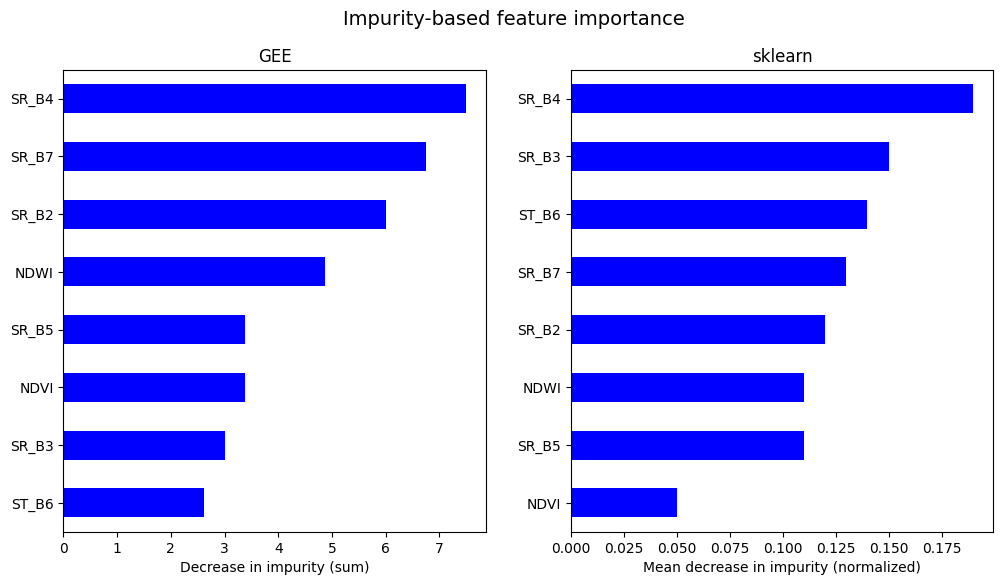

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

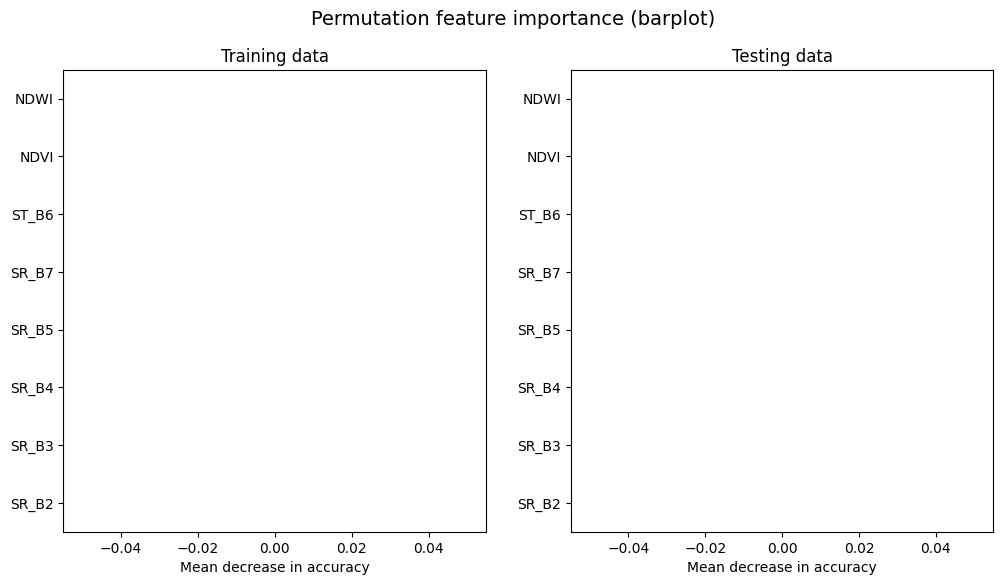

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

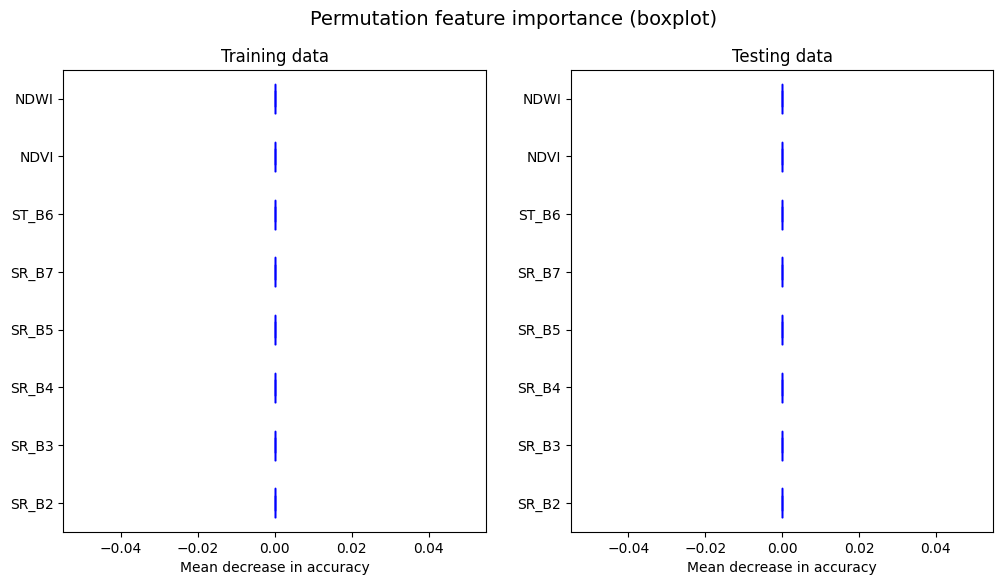

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


SHAP values summary plot for all classes


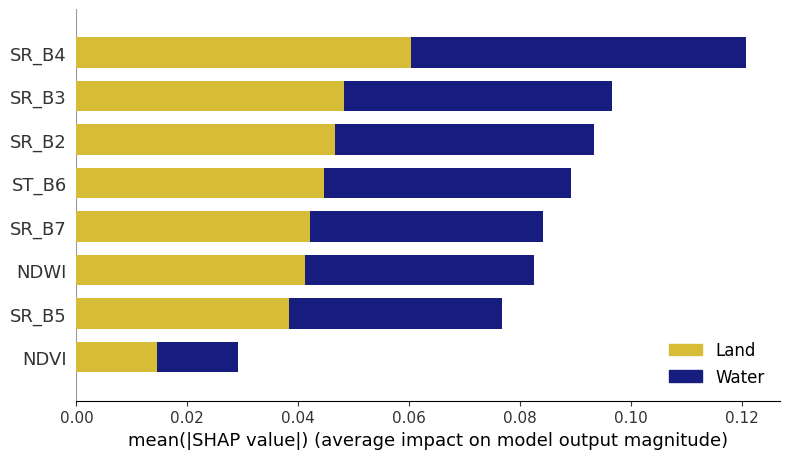


 Shap values plot for selected class


Dropdown(description='Select class name', layout=Layout(width='max-content'), options=('Land', 'Water'), style…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…


 Dependence plots for selected features


Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Select compute checkbox to calculate zonal areas.


Checkbox(value=False, description='Compute')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Classifying temporal composite ...


""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

HTML(value='<h3>Export classified image collections</h3>')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

HTML(value='<h3>Display image thumbnails at select dates</h3>')

interactive(children=(SelectMultiple(description='Select dates', index=(0, 1, 2), options=(1999, 2000, 2001, 2…

Button(description='Add selected to map', style=ButtonStyle(), tooltip='Add classified image layers to map')

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Calculating zonal areas for the classified composite ...




interactive(children=(IntSlider(value=45, continuous_update=False, description='Label rotation', max=90, style…

<IPython.core.display.Javascript object>

In [39]:
createTabs()